In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt
import keras.backend as K
from keras.callbacks import EarlyStopping

C:\Users\Artem\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<div>
<img src="images/ml_flow.png" width="500"/>
</div>

In [2]:
#acquire data from excel
data = pd.read_excel("dataset/POF2018_A.xlsx",header=0)

#convert the data to datetime format
data['Date'] = pd.to_datetime(data["Date_1"]).dt.date

#delete date_1 column
del data['Date_1']

data

,Serial_Number,Sequence_number,Part_Type,Product_Type,Date
0,5240356,8602,Type_E,Product_B,2018-01-02
1,5140145,8603,Type_C,Product_A,2018-01-02
2,5110392,8604,Type_E,Product_A,2018-01-02
3,4930177,8605,Type_D,Product_A,2018-01-02
4,5250312,8606,Type_E,Product_B,2018-01-02
...,...,...,...,...,...
222770,210133,1431,Type_B,Product_A,2018-12-21
222771,210184,1432,Type_E,Product_A,2018-12-21
222772,170520,1433,Type_E,Product_C,2018-12-21
222773,170215,1434,Type_B,Product_A,2018-12-21


In [3]:
#preparing the data for the ML algorithm
#values parameter defines the column to which the function is applied, in this case the number of products 
#the goal is to get the number of batteries installed during every single day 
dataset = data.pivot_table(values='Serial_Number', index='Date', columns='Part_Type', aggfunc=len)
#dataset.reset_index(inplace = True, drop = True)
#the empty cells are filled with zeros
dataset = dataset.fillna(0)
dataset.reset_index(inplace=True)
print(dataset)

#delete the columns that are not needed
new_dataset = dataset.drop(['Date', 'Type_A', 'Type_B', 'Type_C', 'Type_D'], axis = 1)
#convert dataframe to matrix, to work with the list
dataset_E = new_dataset.values
#converting the entire column to the float type
dataset_E = dataset_E.astype('float32')

Part_Type        Date  Type_A  Type_B  Type_C  Type_D  Type_E
0          2018-01-02    23.0    16.0   150.0   269.0   136.0
1          2018-01-03    19.0    35.0    36.0   349.0   364.0
2          2018-01-04    21.0    40.0    49.0   183.0   550.0
3          2018-01-05    14.0    29.0    31.0   519.0   263.0
4          2018-01-06     8.0     4.0    39.0   184.0    83.0
..                ...     ...     ...     ...     ...     ...
295        2018-12-17   104.0    50.0    52.0   226.0   445.0
296        2018-12-18    36.0    32.0   124.0   349.0   364.0
297        2018-12-19    40.0     8.0    85.0   347.0   386.0
298        2018-12-20    33.0    82.0   113.0   278.0   421.0
299        2018-12-21     7.0    14.0    23.0    74.0    93.0

[300 rows x 6 columns]


In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_E = scaler.fit_transform(dataset_E)
print(dataset_E.shape[0], dataset_E.shape[1])
dataset_E

300 1


array([[0.2042042 ],
       [0.5465466 ],
       [0.82582587],
       [0.3948949 ],
       [0.12462462],
       [0.        ],
       [0.33033034],
       [0.33333334],
       [0.5       ],
       [0.32282284],
       [0.3123123 ],
       [0.12012012],
       [0.0015015 ],
       [0.34984985],
       [0.3873874 ],
       [0.36036038],
       [0.43393394],
       [0.44294295],
       [0.2702703 ],
       [0.0015015 ],
       [0.41891894],
       [0.45045045],
       [0.44894895],
       [0.43243244],
       [0.6441442 ],
       [0.21771772],
       [0.0015015 ],
       [0.3873874 ],
       [0.2837838 ],
       [0.21321322],
       [0.32432434],
       [0.5195195 ],
       [0.3858859 ],
       [0.0015015 ],
       [0.46246248],
       [0.33333334],
       [0.31981984],
       [0.3768769 ],
       [0.3663664 ],
       [0.22972974],
       [0.        ],
       [0.26126125],
       [0.2882883 ],
       [0.4039039 ],
       [0.24624625],
       [0.44444445],
       [0.3888889 ],
       [0.396

In [5]:
# split into train and test sets
train_size = int(len(dataset_E) * 0.70)
train, test = dataset_E[0:train_size,:], dataset_E[train_size:len(dataset_E),:]
print(len(train), len(test))

210 90


<div>
<img src="images/LSTM_cell.png" width="500"/>
</div>

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, backsteps):
    dataX, dataY = [], []
    for i in range(len(dataset)-backsteps-1):
        a = dataset[i:(i+backsteps), 0]
        dataX.append(a)
        dataY.append(dataset[i + backsteps, 0])
    return np.array(dataX), np.array(dataY)

<div>
<img src="images/lstm_input.png" width="500"/>
</div>

In [23]:
#create the test and train datasets, define the number of back steps
backsteps = 12
trainX, trainY = create_dataset(train, backsteps)
testX, testY = create_dataset(test, backsteps)

#reshape into appropriate format to be fed to LSTM [samples, time_steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
print(trainX.shape[0], trainX.shape[1], trainX.shape[2]) 
print(testX.shape[0], testX.shape[1], testX.shape[2]) 

197 1 12
77 1 12


In [9]:
def model_builder(hp):
    model = Sequential()
    
    #add first layer with specified input vector size
    model.add(LSTM(hp.Int('input_unit', min_value=16, max_value=256, step=32), return_sequences=True, input_shape=(1, backsteps)))
    
    #add further layers with adjusted number of neurons
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=16, max_value=256, step=32), return_sequences=True))
    
    #add the last layer before dropout and Dense layers
    model.add(LSTM(hp.Int('layer_2_neurons', min_value=16, max_value=256, step=32)))
    
    #add dropout layer
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)))
    
    #add dense layer
    model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'sigmoid'], default='relu')))
    
    #compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.LogCoshError(), \
                                                                        tf.keras.metrics.RootMeanSquaredError()])
    return model

In [10]:
stop_early = EarlyStopping(monitor='val_mae', patience=5, verbose=1, restore_best_weights=True, start_from_epoch=25)

#start searching for the parameters
tuner= RandomSearch(model_builder, objective='val_mae', max_trials=5, executions_per_trial=4)#, executions_per_trial=3)

tuner.search(x=trainX, y=trainY, epochs=100, batch_size=64, validation_data=(testX, testY), callbacks=[stop_early])

#acquire best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

#build the model with optimal hyperparameters and train it 
model = tuner.hypermodel.build(best_hps)


history = model.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), callbacks=[stop_early])

model.summary()

Reloading Tuner from .\untitled_project\tuner0.json
Epoch 1/100
7/7 [==============================] - 11s 351ms/step - loss: 0.1984 - mse: 0.1984 - mae: 0.3901 - logcosh: 0.0936 - root_mean_squared_error: 0.4454 - val_loss: 0.1737 - val_mse: 0.1737 - val_mae: 0.3909 - val_logcosh: 0.0836 - val_root_mean_squared_error: 0.4168
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 0.1586 - mse: 0.1586 - mae: 0.3494 - logcosh: 0.0755 - root_mean_squared_error: 0.3983 - val_loss: 0.1173 - val_mse: 0.1173 - val_mae: 0.3147 - val_logcosh: 0.0570 - val_root_mean_squared_error: 0.3425
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0960 - mse: 0.0960 - mae: 0.2648 - logcosh: 0.0462 - root_mean_squared_error: 0.3099 - val_loss: 0.0362 - val_mse: 0.0362 - val_mae: 0.1583 - val_logcosh: 0.0179 - val_root_mean_squared_error: 0.1902
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0491 - mse: 0.0491 - mae: 0.1679 - logcosh: 0.0238

Epoch 31/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.1117 - logcosh: 0.0112 - root_mean_squared_error: 0.1512 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.1101 - val_logcosh: 0.0100 - val_root_mean_squared_error: 0.1419
Epoch 32/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0228 - mse: 0.0228 - mae: 0.1120 - logcosh: 0.0112 - root_mean_squared_error: 0.1510 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1096 - val_logcosh: 0.0100 - val_root_mean_squared_error: 0.1423
Epoch 33/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.1134 - logcosh: 0.0113 - root_mean_squared_error: 0.1512 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1100 - val_logcosh: 0.0101 - val_root_mean_squared_error: 0.1425
Epoch 34/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.1117 - logcosh: 0.0109 - root_mean_squared_error: 0.1491 - val_loss: 0.0

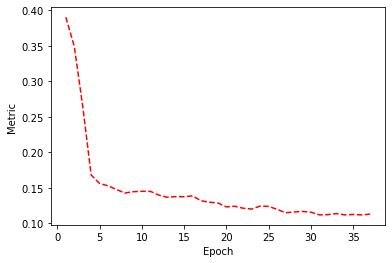

In [11]:
# Get training and test loss histories
training_loss = history.history['mae']
test_loss = history.history['val_mae']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show();

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#invert the predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
rmse_testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
mae_testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('RMSE Score: %.2f RMSE' % (rmse_testScore), ' MAE: %.2f' % (mae_testScore))

3/3 [==============================] - 0s 5ms/step
RMSE Score: 94.74 RMSE  MAE: 72.99


<div>
<img src="images/assessment_table.png" width="500"/>
</div>

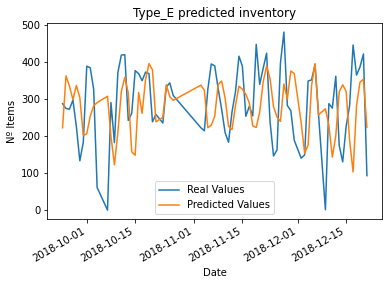

In [13]:
n=backsteps + 1
date_to_plot = dataset["Date"].tail(len(testPredict))

real_data = np.round(scaler.inverse_transform(test[n:]), 0)
pred_data = np.round(testPredict, 0)

df_plot = pd.DataFrame({'date': date_to_plot.ravel(), 'real_values': real_data.ravel(), 'predictions': pred_data.ravel()})
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot.set_index('date')

df_plot.to_excel("predictions_Type_E_v2.xlsx")

plt.plot(df_plot['date'], df_plot['real_values'], label = 'Real Values')
plt.plot(df_plot['date'], df_plot['predictions'], label = 'Predicted Values')
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('Type_E predicted inventory')
plt.xlabel('Date')
plt.ylabel('Nº Items')

plt.show()